-----------------------
# <font color='blue'>**Time Series - LSTM + CNN** </font>
-----------------------

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_series, plot_series_2, trend, seasonal_pattern
from utils import seasonality, noise, generate_synthetic_timeseries
from utils import windowed_dataset, model_forecast

#### <font color='magenta'> 1) Generating Synthetic Data </font>

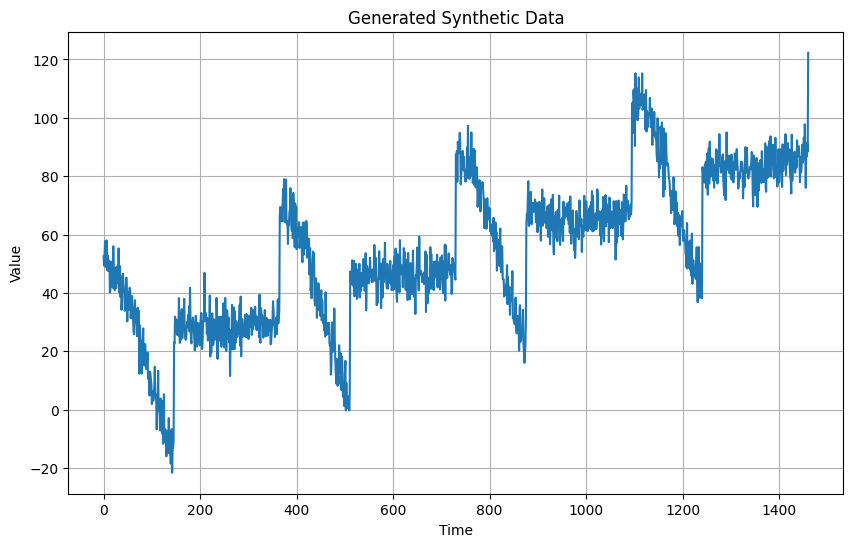

In [2]:
series, time = generate_synthetic_timeseries()
plot_series(time, series, title='Generated Synthetic Data')

#### <font color='magenta'> 2) Splitting the Dataset </font>

In [3]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### <font color='magenta'> 3) Preparing features and labels </font>

In [4]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### <font color='magenta'>4) Build the Model </font>

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [5]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


#### <font color='magenta'> 5) Tuning the Learning Rate </font>

In the previous labs, we are using different models for tuning and training. 

That is a valid approach but we can also use the same model for both. 

Before tuning, we can use the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method so that we can reset it later.

In [6]:
# Get initial weights
init_weights = model.get_weights()



# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


62/62 [==============================] - 12s 21ms/step - loss: 42.1189 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 14ms/step - loss: 31.1313 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 13ms/step - loss: 26.6078 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 1s 12ms/step - loss: 21.0121 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 1s 12ms/step - loss: 16.3507 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 13.7024 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 1s 12ms/step - loss: 12.1334 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 1s 11ms/step - loss: 11.3428 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 1s 11ms/step - loss: 10.8653 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 1s 12ms/step - loss: 10.5604 - lr: 2.8184e-08
Epoch 11/100
62/62 [

(1e-08, 0.001, 0.0, 50.0)

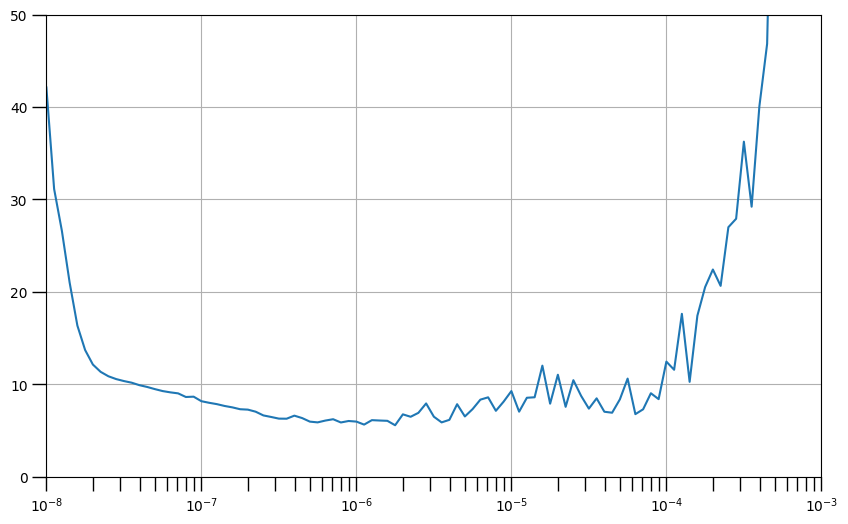

In [7]:
# Plotting the Learning Rate Curve
# --------------------------------
lrs = 1e-8 * (10 ** (np.arange(100) / 20))          # Define the learning rate array
plt.figure(figsize=(10, 6))                         # Set the figure size
plt.grid(True)                                      # Set the grid
plt.semilogx(lrs, history.history["loss"])          # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')       # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 50])                       # Set the plot boundaries

#### <font color='magenta'> 6) Training the Model </font>

In [8]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500


62/62 [==============================] - 4s 14ms/step - loss: 25.8607 - mae: 26.3537
Epoch 2/500
62/62 [==============================] - 1s 12ms/step - loss: 11.4504 - mae: 11.9326
Epoch 3/500
62/62 [==============================] - 1s 12ms/step - loss: 10.2820 - mae: 10.7697
Epoch 4/500
62/62 [==============================] - 1s 13ms/step - loss: 9.7548 - mae: 10.2414
Epoch 5/500
62/62 [==============================] - 1s 13ms/step - loss: 9.3767 - mae: 9.8630
Epoch 6/500
62/62 [==============================] - 1s 14ms/step - loss: 8.8156 - mae: 9.3027
Epoch 7/500
62/62 [==============================] - 1s 14ms/step - loss: 8.5883 - mae: 9.0735
Epoch 8/500
62/62 [==============================] - 1s 13ms/step - loss: 8.3440 - mae: 8.8278
Epoch 9/500
62/62 [==============================] - 1s 13ms/step - loss: 8.0419 - mae: 8.5263
Epoch 10/500
62/62 [==============================] - 1s 13ms/step - loss: 7.8387 - mae: 8.3213
Epoch 11/500
62/62 [==============================] - 

Training can be a bit unstable especially as the weights start to converge so we may want to visualize it to see if it is still trending down. 

The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. 

The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

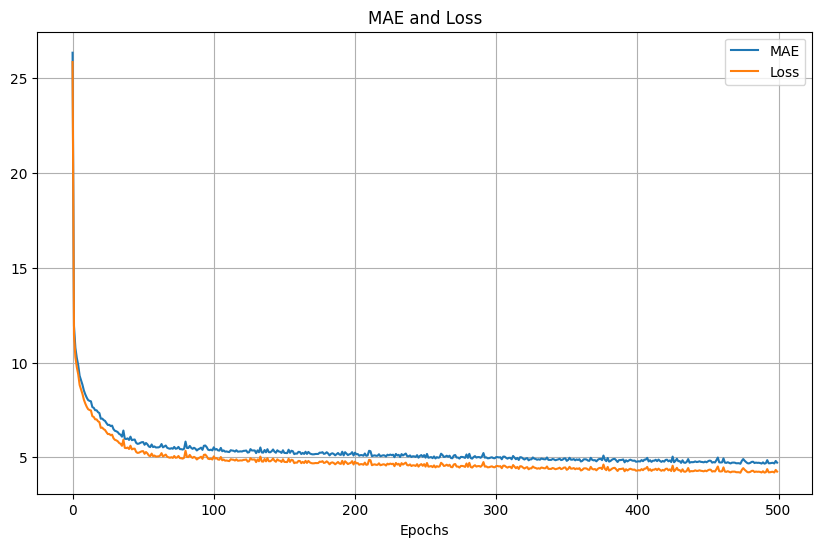

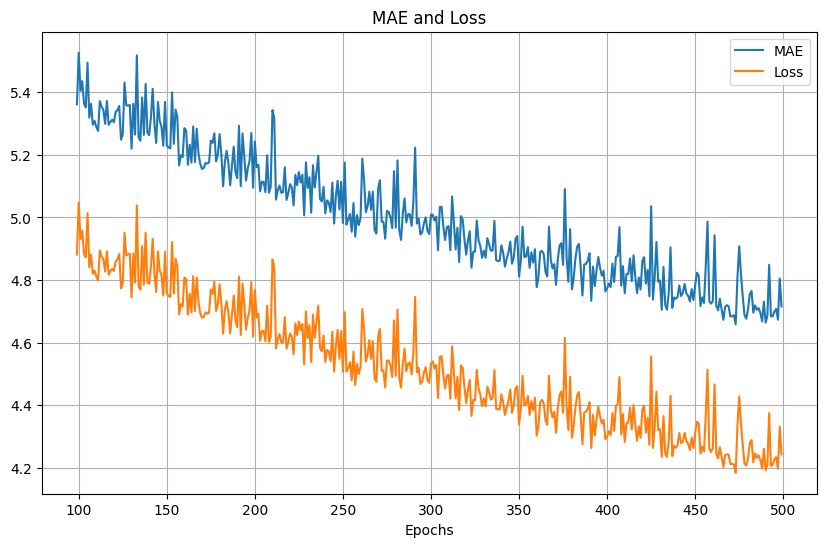

In [9]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series_2(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series_2(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

#### <font color='magenta'> 7) Predicting from the Model </font>

      1/Unknown - 0s 42ms/step

29/29 [==============================] - 0s 11ms/step
MSE:  53.020184
MAE:  5.2521257


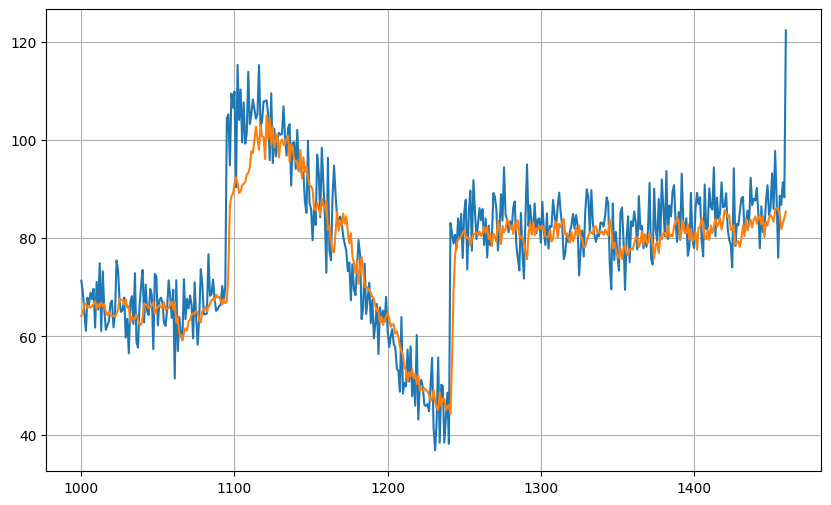

In [11]:
def model_forecast(model, series, window_size, batch_size):
    """
    Uses an input model to generate predictions on data windows
    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast



# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

## Compute the MAE and MSE
print("MSE: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Plot the results
plot_series_2(time_valid, (x_valid, results))

#### <font color='magenta'> 8) Adding callback for early stopping </font>

We can add a callback to stop training when a metric is met.

Epoch 1/500
62/62 [==============================] - 5s 30ms/step - loss: 33.5627 - mae: 34.0594 - val_loss: 24.9512 - val_mae: 25.4483
Epoch 2/500
62/62 [==============================] - 1s 16ms/step - loss: 17.2395 - mae: 17.7315 - val_loss: 7.1618 - val_mae: 7.6461
Epoch 3/500
62/62 [==============================] - 1s 16ms/step - loss: 11.9506 - mae: 12.4387 - val_loss: 7.3038 - val_mae: 7.7908
Epoch 4/500
62/62 [==============================] - 1s 16ms/step - loss: 10.9095 - mae: 11.3964 - val_loss: 6.8967 - val_mae: 7.3774
Epoch 5/500
62/62 [==============================] - 1s 16ms/step - loss: 10.4150 - mae: 10.9047 - val_loss: 7.4230 - val_mae: 7.9119
Epoch 6/500
62/62 [==============================] - 1s 15ms/step - loss: 10.1640 - mae: 10.6518 - val_loss: 7.8596 - val_mae: 8.3492
Epoch 7/500
62/62 [==============================] - 1s 16ms/step - loss: 9.9079 - mae: 10.3924 - val_loss: 7.7981 - val_mae: 8.2888
Epoch 8/500
62/62 [==============================] - 1s 17ms/

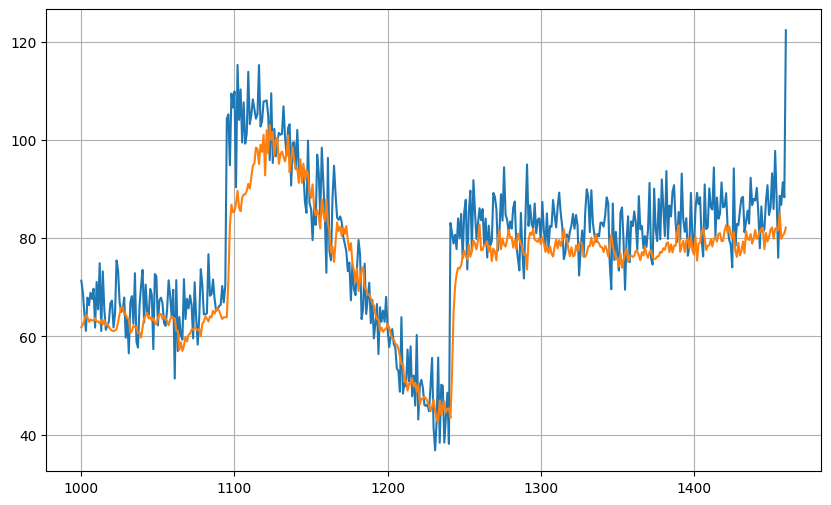

In [13]:
# First, you need to prepare a validation set that the model 
#   can use and monitor. 
# As shown in the previous lab, 
#   you can use the `windowed_dataset()` function to prepare this.
# 
#
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# Uncomment if you want to reset the weights
model.set_weights(init_weights)

# Next, we will define a callback function that is run every end of an epoch. 
# Inside, you will define the condition to stop training. 
# For this lab, you will set it to stop when the `val_mae` is less than `5.2`.
# 
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met
    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''    
    if(logs.get('val_mae') < 5.2):          # Check the validation set MAE
      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

# Remember to set an appropriate learning rate here. 
# If you're starting from random weights, 
#   you may want to use the same rate you used earlier. 
# If you did not reset the weights however, 
#   you can use a lower learning rate so the model can learn better. 
# If all goes well, the training will stop before the set 500 epochs are completed.
# 
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, 
                    epochs=500, 
                    validation_data=val_set, 
                    callbacks=[callbacks])
#
# In practice, you normally have a separate test set to evaluate against unseen data. 
# For this exercise however, the dataset is already very small so 
#   let's just use the same validation set just to verify that the 
#   results are comparable to the one you got earlier.
#
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

## Compute the MAE and MSE
print("MSE: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Plot the results
plot_series_2(time_valid, (x_valid, results))

The computed metrics here will be slightly different from the one shown in the training output because it has more points to evaluate. Remember that `x_valid` has 461 points that corresponds to `t=1000` to `t=1460`. `val_set` (which is a windowed dataset from `x_valid`), on the other hand, only has 441 points because it cannot generate predictions for `t=1000` to `t=1019` (i.e. windowing will start there).

------------------------------
------------------------------
------------------------------